## OpenAI Bipedal Walker Environment: Continuous Actions and Large State-Spaces

  This is 4-jointed Bipedal Robot who must reach the end of the 2-Dimensional environment.The ground is randomly generated for each episode, but done so differently for each version.
 
  There are two versions:
 
  - **Normal**, with slightly uneven terrain.

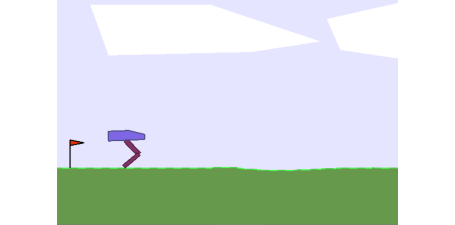
    
   - **Hardcore** with ladders, stumps, pitfalls.

  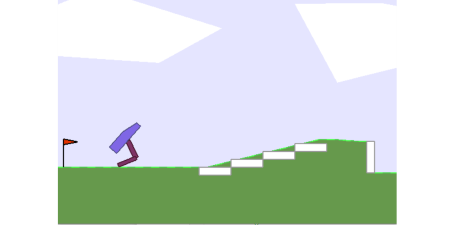
  
  
We are using the Normal environment to prototype the Deep Deterministic Policy Gradient (DDPG).


#### Source

  The BipedalEnvironment was created by Oleg Klimov and is licensed on the same terms as the rest of OpenAI Gym.  
  Raw environment code: https://github.com/openai/gym/blob/master/gym/envs/box2d/bipedal_walker.py  


### Rewards Given to the Agent

  - Moving forward, total 300+ points up to the far end. 
  - If the robot falls, it gets -100. 
  - Applying motor torque costs a small amount of points, more optimal agent will get better score.

### State Space: 24 Dimensions

  - **4 hull measurements**: angle speed, angular velocity, horizontal speed, vertical speed
  - **8 joint measurements**, 2 for each of the 4 joints: position of joints and joints angular speed 
  - **2 leg measurements**, one for each leg: legs contact with ground
  - **10 lidar rangefinder measurements** to help to navigate the hardcore environment. 
  
### What quantifies a solution, or a sucessful RL agent?
  
  To solve the game you need to get **300 points in 1600 time steps**.
 
  To solve the hardcore version you need **300 points in 2000 time steps**.



In [88]:
import gym
import numpy as np


class NeedsToBeImplemented(Exception):
    pass


class Environment():
    
    def __init__(self, environment = 'BipedalWalker-v2', iterations= 1000):
        
        self.iterations = iterations
        self.env = gym.make(environment)
        self.env.reset()
    
    def test_environment(self, render = True, action = np.array([0,0,0,0]), debug = False):
        
        start_index = 0
        
        episode_rewards = []
        episode_states = []
        states = []
        rewards = []
        
        for i in range(1000):
            
            if render:
                self.env.render()
            
            state, reward, terminal, info = self.env.step(action)
            episode_rewards.append(reward)
            episode_states.append(state[2])
            
            if terminal:
                if debug:
                    print('Episode finished after {} timesteps: '.format(i-start_index))
                    print(f"State: {state}\nReward: {rewards}")
                
                rewards.append(episode_rewards)
                states.append(episode_states)
                episode_rewards = []
                episode_states = []
                start_index = i
                self.env.reset()

        self.env.close()
        
        return states, rewards
        
    def model(self):
        
        
        raise NeedsToBeImplemented('To Do!')
        
        

In [89]:
env = Environment()

## Testing

Evaluating how appropriate a given $s'$ value is for each action across a continous action space can be very difficult. 

To approach testing the environment, I chose a discrete action to be applied throughout the entire duration of each episode.

#### Test 1 - Action Vector: [1,0,1,0]
Full Torque is constantly applied at just the knees,causing the agent to bend its knees and fall backwards because the hull is more weighted towards the back.
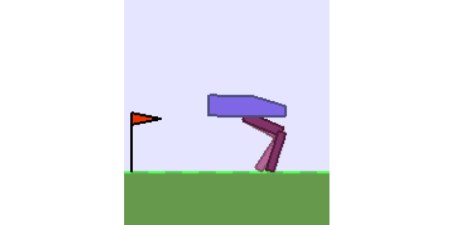

In [90]:
action =  np.array([1,0,1,0])
states, rewards = env.test_environment(render=False, action = action)

In [91]:
import matplotlib.pyplot as plt

def visualize_rewards(rewards):
    ## Convert to Numpy Arrays
    
    arrays = []
    for i, episode in enumerate(rewards):
        arrays.append(np.array(episode))
    plot_rewards(arrays)
    
def plot_rewards(arrays):
    ## Plot the Episodes
    
    plt.figure(figsize = (12,10))

    for i, array in enumerate(arrays):

        assert array[-1] == -100    ## Validate that a reward of -100 is reached upon termination
        plt.plot(array[:-1], label = f"Episode {i}")

    plt.title(f"Reward Over Time for Uniform Action Across {len(arrays)} Episodes")
    plt.xlabel("Time")
    plt.ylabel("Reward")
    plt.legend()


### Plotting the Reward Across Time for Many Episodes

##### Note: The ground is randomly generate for each episode; there is a difference in the rewards for each episode due to the random initialization!
Since the Agent is rewarded for making forward progress, they should receive a negative reward for moving backwards.   

Insights from our visualization:
1. We see the rewards spike to $0.1$ in the beginning, since the forward knee bend causes the agent to move slightly forward
2. The reward declines as the agent begins to fall backwards, much further than it went forward, to $-0.4$ reward.
3. A reward of $-100$ is given upon episode termination and I omit this from the graph since it is an outlier

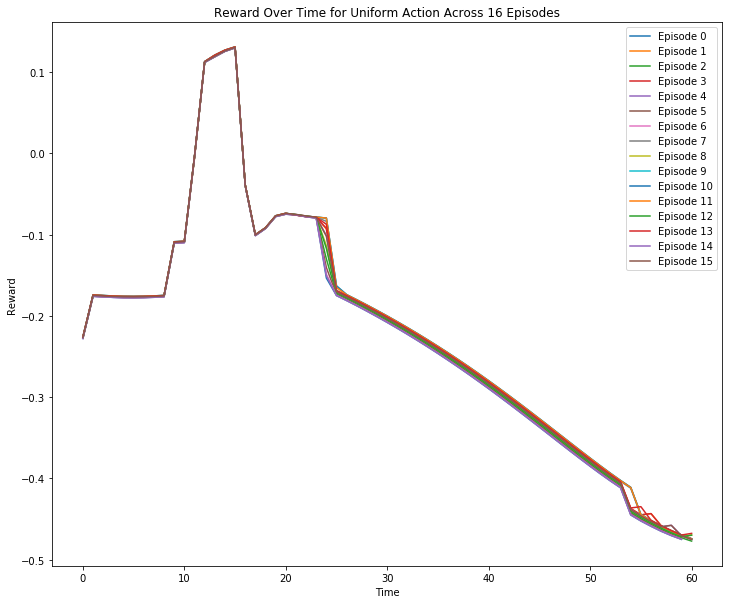

In [97]:
visualize_rewards(rewards)

##  Resulting States from Other Actions:

#### Action Vector: [0, 0, 1, 1]
Full positive torque is constantly applied to the knee and hip joints of the right leg. The leg stiffens up and extends in front of the walker while the limp leg slowly bends from the force of gravity. The walker falls backwards.

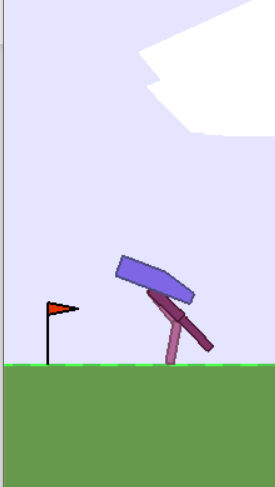

#### Action Vector: [0, 0, -1, -1]
Full negative torque is constantly applied to the knee and hip joints of the right leg. The leg bends backwards and stays bent, so gravity forces the walker forward, causing it to fall over.

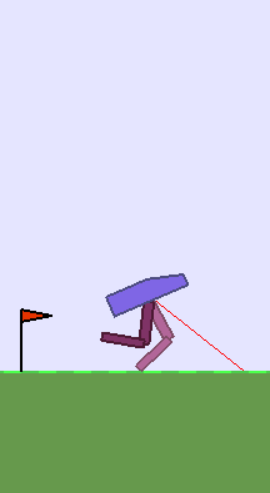

#### Action Vector: [0, 0, 0, 0]
Zero torque is applied at every time step. The legs go limp and the agent falls over.

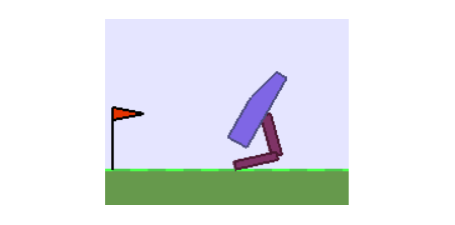



In [103]:
def visualize_states(arrays):
    ## Plot the Episodes
    
    plt.figure(figsize = (12,10))

    for i, array in enumerate(arrays):

        plt.plot(array[:-1], label = f"Episode {i}")

    plt.title(f"X Velocity Over Time for Uniform Action Across {len(arrays)} Episodes")
    plt.xlabel("Time")
    plt.ylabel("X Velocity")
    plt.legend()


### Plotting the X Velocity, a State Feature, Across Time for Many Episodes

##### Note: The ground is randomly generate for each episode; there is a difference in the rewards for each episode due to the random initialization!

The agent behaves as we'd expect: with fully locked knees, the agent moves forward when it first bends them, then falls backwards. The X Velocity feature of our state space captures this perfectly, showing a similar distribution to the reward plots -- Positive in the beginning, then very negative as the agent falls backwards.

Insights from our visualization:
1. We see the x velocity spike in the beginning, which is why we also receive a positive reward.
2. The reward declines as the agent begins to fall backwards and the x velocity goes negative due to backwards movement.
3. The reward function is closely linked to this state feature, x velocity.

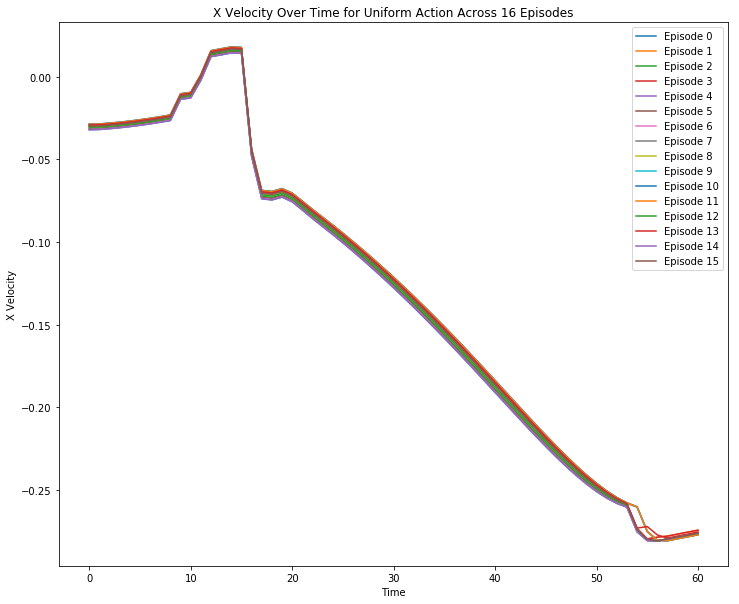

In [105]:
visualize_states(states)